<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/Lecture_2_Signals_in_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install lalsuite


    100% |████████████████████████████████| 30.3MB 979kB/s 
    100% |████████████████████████████████| 51kB 16.9MB/s 
    100% |████████████████████████████████| 1.6MB 5.9MB/s 
    100% |████████████████████████████████| 61kB 14.0MB/s 
    100% |████████████████████████████████| 2.3MB 10.8MB/s 
    100% |████████████████████████████████| 102kB 28.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/5d/1e/4a/ab4122baed7d67f6abce65b2b12049d3bc7fe5dad24edf89df
  Stored in directory: /root/.cache/pip/wheels/aa/fa/38/d61b002c627ca54f03755b9a288f4b1fa83291608a4bc47b7b
Successfully built ligo-segments lscsoft-glue


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pylab as plt
plt.style.use('default')
from scipy.stats import norm
%matplotlib inline
from IPython.display import set_matplotlib_formats
from IPython.display import clear_output
set_matplotlib_formats('retina')

import scipy 
from matplotlib import rc

from scipy.interpolate import interp1d
import lal
import lalsimulation as lalsim

import sys



font = {'family' : 'sans serif',
        'weight': 'regular',
        'size'   : 20}

rc('font', **font)
#rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (0.4*8*1.9, 0.4*1.9*4*1.2)

# Foundations of gravitational-wave astronomy and inference on LIGO data



* Basics of Bayesian inference
    * Conditional probabilities and "Bayes Theorem"
* Hypothesis testing and model selection
    * The Odds Ratio
    * Worked example
* Joint Parameter estimation and hypothesis testing 
    * Likelihoods, Priors and Evidences
    * Posterior probability density functions
    * Worked example
* Occam's Razor


Our overall goal is to learn how to assign confidence to detevtions of gravitational-wave signals and understand their properties via plots like this:

<img src="https://docs.google.com/uc?export=download&id=1sscv0Gzn8QdT-9VcEHutMqRS63QWaD3s" width="300">




# Inspecting the data

Let's start by generating our data set. It has two components: a gravitational-wave signal, and aLIGO-like noise.

The signal corresponds to the (Fourier transform) of a gravitational-wave signal which originated from the merger of two black holes with the following properties:


---


* $m_1 = m_2 = 30M_{\odot}$
* $ D = 1.5\text{Gpc} = 1500\text{Mpc}$
* $\iota = 0$
* $\vec{S}^1 = (0,0,0)$
* $\vec{S}^2 = (0,0,0)$
* $ \phi_c = 0$


---



In [0]:
import pandas as pd

data_csv = pd.read_csv("/content/gdrive/My Drive/InvisibleUniverse/Data/fake_data_for_lectures.csv")
noise_csv = pd.read_csv("/content/gdrive/My Drive/InvisibleUniverse/Data/fake_noise_for_lectures.csv")
signal_csv = pd.read_csv("/content/gdrive/My Drive/InvisibleUniverse/Data/fake_fdomain_signal_for_lectures.csv")

In [0]:
freqs = data_csv['# f']
deltaF = freqs[1]-freqs[0]
data = data_csv['data_real'] + 1j*data_csv['data_imag']
noise = noise_csv['noise_real'] + 1j*noise_csv['noise_imag']
psd = noise_csv['psd']
signal = signal_csv['htilde_real'] + 1j*signal_csv['htilde_imag']

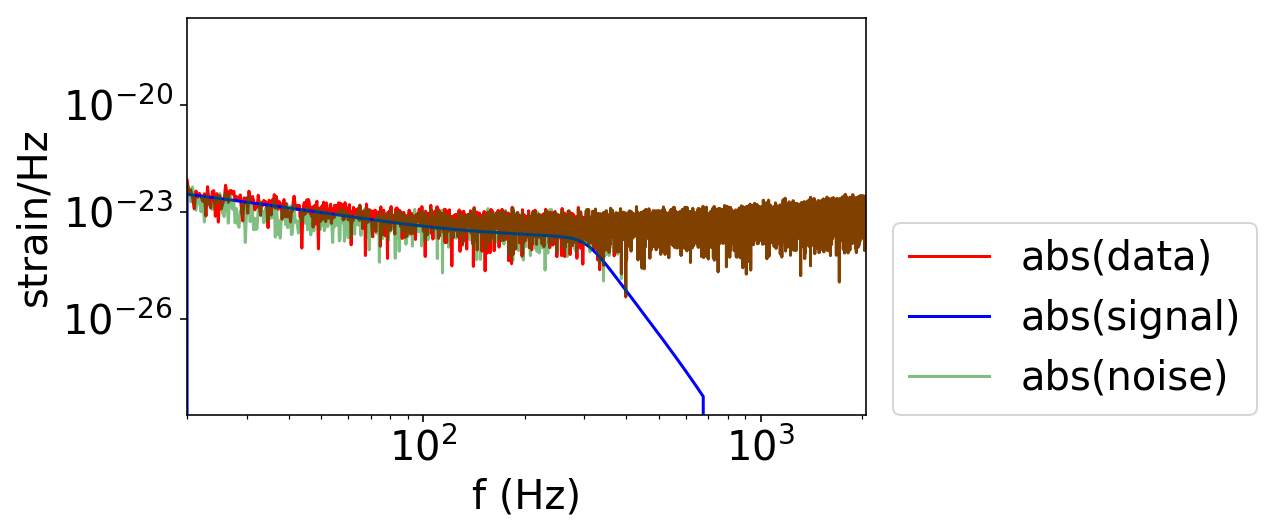

In [0]:
plt.loglog(freqs,np.absolute(data),label='abs(data)',c='red')
plt.loglog(freqs,np.absolute(signal),label='abs(signal)', c='blue')
plt.loglog(freqs,np.absolute(noise),label='abs(noise)',alpha=0.5,c='green')

plt.xlabel('f (Hz)')
plt.ylabel('strain/Hz')
plt.xlim(20,2048)
plt.legend(loc=(1.04,0))
plt.savefig("/content/gdrive/My Drive/InvisibleUniverse/images/data_sig_noise.png",bbox_inches='tight',dpi=100)

The data $d(f)$ here contains a synthetic gravitational-wave signal $h(f)$ and colored Gaussian noise $n(f)$, i.e.,
​
* $d(f) = h(f) + n(f)$

Notice that the units of the Fourier transform of the time-domain strain is $\text{strain/Hz}$ (c.f. the ASD which has units $\text{strain/}\sqrt{Hz}$)

# How do we tell if the data contains a signal?



Let's imagine we’re given the data without $\textit{a priori}$ knowledge of whether it contains a signal or not.

* $\textbf{Question: is the data more consistent with noise, or noise + signal?}$
    * For now, assume that the signal has two "features": it can either be "on" or "off", i.e., has no unknown parameters

Our first goal will be to answer the above question. We will use this example to introduce the idea of $\textbf{hypothesis testing}$ in the context of Bayesian Inference.

To begin, let's define some variables and build up our inference machine.

We will start by introducing three basic "ingredients" for hypothesis testing with which we will model our data:


---



* $d$: Observational data
* $\mathcal{H}_i$: An hypothesis that describes the data. For example, we could have a "noise" hypothesis $\mathcal{H}_N$ that says "the data are colored Gaussian noise with known mean and variance". A competing hypothesis could be the "signal" hypothesis $\mathcal{H}_S$ which says "The data are colored Gaussian noise with known mean and variance $\textit{plus} a gravitational wave signal$". In general, there could be an infinite number of hypotheses we could test with our data.
* $I$: "Prior" information. This is $\textit{a priori}$ knowledge about our expectations for the hypotheses before we learn from our data. For instance, we might give equal odds to their being a signal or noise.


---


These three ingredients are the inputs to our inference machine. What about the "machine" itself ,and the outputs?



# Conditional probability and Bayes Theorem
## Axiom 0: Data are *uncertain*

The Bayesian inference machine is just a conditional probability. Let's look at the specific case of hypothesis testing. We'd like to be able to assign a probability to an hypothesis $\mathcal{H}_i$, given the data $d$ and our prior information $I$. In the formalism of conditional probabilities, we seek to compute: 


---


* $P(\mathcal{H}_i |d,I)=\frac{P(\mathcal{H}_i|I)P(d|\mathcal{H}_i,I)}{P(d|I)}$


---


In the context of Bayesian inference, we usually refer to the above as "$\textbf{Bayes Theorem}$" after Reverend Thomas Bayes (1701–1761).

Each term has a name. We'll change our notation and naming convention when we introduce free parameters, for now though we'll use the following definitions:


---


* $P(\mathcal{H}_i |d,I)$ : $\textbf{Posterior Probability Density Function (PDF)}$ of the hypothesis $\mathcal{H}_i$. Posterior refers to $\textit{a postiori}$, i.e., what we know about $\mathcal{H}_i$ after we analyze the data $d$.
* $P(\mathcal{H}_i|I)$: $\textbf{Prior Probability}$ of the hypothesis $\mathcal{H}_i$. Prior refers to $\textit{a priori}$, i.e., what we think we know about $\mathcal{H}_i$ before we analyze our data.
* $P(d|\mathcal{H}_i,I)$: $\textbf{Evidence}$ for the data. This is the probability of the $\textbf{data}$ given our hypothesis $\mathcal{H}_i$
* $P(d|I)$: $\textbf{Marginal Likelihood}$. This is the probability of the data, given all possible hypotheses $P(d|I)=\sum_i P(\mathcal{H}_i|I)P(d|\mathcal{H}_i,I)$


---


In general, we could have an infinite number of hypotheses. In lieu of being able to weight on hypothesis against all possible hypotheses, we usually work by comparing two hypotheses at a time. This leads us to the $\textbf{Odds Ratio}$.


# Hypothesis Testing: The Odds Ratio

Assume for the moment that we know how to evaluate $P(\mathcal{H}_i |d,I)$ for any hypotheses (we'll look at an example shortly). How can we leverage the posterior probability to perform hypothesis testing?

A natural way is to take $\textit{ratios of posterior probabilities}$. This allows us to compute the relative probability of hypothesis $\mathcal{H}_S$ against a competing hypothesis $\mathcal{H}_N$.

The ratio is known as the $\textbf{Odds Ratio}$ and is a cornerstone of inference. The odds ratio is


---
* $O_{S,N}=\frac{P(\mathcal{H}_S |d,I)}{P(\mathcal{H}_N |d,I)}$

Expanding out the probabilitities


* $O_{S,N}=\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}\frac{P(d|\mathcal{H}_S,I)}{P(d|\mathcal{H}_N,I)}=\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}B_{S,N}\,;
$


---


(notice that the marginal likelihood cancels out)

There are two components:


---


* $\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}$: $\textbf{Prior Odds}$, i.e., the odds before we collect and analyze data
* $B_{S,N} \equiv \frac{P(d|\mathcal{H}_S,I)}{P(d|\mathcal{H}_N,I)}$: $\textbf{Posterior Odds}$ or $\textbf{Bayes Factor}$, i.e., the odds after we analyze the data.


---




## Worked example: Picking out the GW signal

Let's work our way through the first question that was posed at the beginning of the Lecture. If we're given the data, can we tell if they contain a signal $\textit{plus}$ noise, or just noise?

<img src="https://docs.google.com/uc?export=download&id=1-1aAls9ANI31whooIiwA2N7IPYYpB5Re" width="550">

The data $d(f)$ here contains a synthetic gravitational-wave signal $h(f)$ and colored Gaussian noise $n(f)$, i.e.,

* $d(f) = h(f) + n(f)$

## Our objective

Our objective is to compute the Odds Ratio for $\mathcal{H}_S$ vs $\mathcal{H}_N$:


---
$\textbf{The Odds ratio (our objective function)}$

$O_{S,N}=\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}\frac{P(d|\mathcal{H}_S,I)}{P(d|\mathcal{H}_N,I)}$


---


We need to compute the prior odds and the posterior odds (Bayes factor). Starting with the prior odds: Let's imagine we have good knowledge about our experiment and that the probability of getting a signal is the same as probability of getting just noise:

* $P(\mathcal{H}_S|I) = P(\mathcal{H}_N|I)$

This might not be true for all experimemtns, but it simplifies our example without sacrificing any generality. The Odds ratio is then just

* $O_{S,N}=\frac{P(d|\mathcal{H}_S,I)}{P(d|\mathcal{H}_N,I)}$


Our task, then, is to evaluate the evidences:

* The "noise" evidence $P(d|\mathcal{H}_N,I)$.

* The "signal" evidence $P(d|\mathcal{H}_S,I)$  


### Hypotheses


Our objective is to compute the Odds ratio which measures the relative probability that the data are described the a noise hypothesis or a signal hypothesis.

We'll start with a simple case in which our data can either be pure Gaussian noise, or Gaussian noise with a known signal. Our aim will be to compute the Odds ratio that compares the two hypotheses. Writing things out a bit more formally, our hypotheses look like this:


---


$\textbf{Noise Hypothesis}$
* $\mathcal{H}_N: d(f_k) = n(f_k)$

with

* $\text{Re}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $
* $\text{Im}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $

and 

* $\sigma^2(f_k) =  \text{PSD}(f_k) / (4\Delta f)$

where 

* $\Delta f$ is the frequency resolution in the Fourier domain (here $\Delta f$ = 1/4 Hz)

and the factor of 4 comes from the definition of the FFT


---


$\textbf{Signal Hypothesis}$
* $\mathcal{H}_S: d(f_k) = s(f_k) + n(f_k)$

with

* $s(f_k) = \tilde{h}(f_k)$ is the GW given in the data file
* $\text{Re}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $
* $\text{Im}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $

and 

* $\sigma^2(f_k) =  \text{PSD}(f_k) / (4\Delta f)$


---




### The "noise" evidence



The "noise evidence" $P(d|\mathcal{H}_N,I)$ is conceptually the easiest to evaluate. Recall that

* $\mathcal{H}_N: d(f_k) = n(f_k)$

with

* $\text{Re}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $
* $\text{Im}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $

and 

* $\sigma^2(f_k) =  \text{PSD}(f_k) / (4\Delta f)$

Thus, the evidence is just the probability that the data are Gaussian:

$P(d|\mathcal{H}_N,I) = \prod_k \Big[\text{Normal}_{\text{PDF}}(\text{Re}\, d_k; \mu=0,\sigma) \times \text{Normal}_{\text{PDF}}(\text{Im}\, d_k; \mu=0,\sigma)\Big]$

And the product follows from each data point being independent. 

We'll find that the numerical values of the probability density will be usually be either extremely small or extremely large, so its best to work with log probabilities. Let's code this up:




In [0]:
from scipy.stats import norm

def log_evidence(data):
    
    data_real = data.values.real
    data_imag = data.values.imag
    
    logL_real = np.sum( norm.logpdf(np.array(data_real), loc=0,
                                    scale=np.sqrt(psd/(4*deltaF))) )
    
    logL_imag = np.sum( norm.logpdf(np.array(data_imag), loc=0,
                                    scale=np.sqrt(psd/(4*deltaF) )))
    
    return logL_real + logL_imag

log_likelihood_noise = log_evidence(data)
print (log_likelihood_noise)

853195.2983053417


Thus the evidence of the data under the noise hypothesis is 

* $P(d|\mathcal{H}_N,I) = 853195.3$

Note that this is a log probability $\textit{density}$: the integrated probability density over all data realizations is still 1. 


### The "signal" evidence

Now we need to compute the likelihood of the data under the signal hypothesis. The "signal likelihood" is more subtle.
We know that we expect the noise to be Gaussian distributed, so we can "rephrase" the signal hypothesis to leverage the statistical uncertainty of the noise:

$\textbf{Signal Hypothesis}$
* $\mathcal{H}_S: n(f_k) = d(f_k) - s(f_k)$

with

* $s(f_k) = \tilde{h}(f_k)$ is the GW given in the data file
* $\text{Re}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $
* $\text{Im}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $

and 

* $\sigma^2(f_k) =  \text{PSD}(f_k) / (4\Delta f)$

Note that this is a $\textit{model}$ for the noise. We expect the residual $d(f_k) - s(f_k)$ to be equal to the noise, which should be Gaussian distributed. Hence we can write the "signal evidence" as 


* $P(d|\mathcal{H}_S,I) = \prod_k \Big[\text{Normal}_{\text{PDF}}(\text{Re}\, \left[d_k - s_k\right]; \mu=0,\sigma) \times \text{Normal}_{\text{PDF}}(\text{Im}\, \left[d_k - s_k\right]; \mu=0,\sigma)\Big]$

In [0]:
 
log_evidence_signal = log_evidence(data-signal)
print(log_evidence_signal)

853804.3884908222


Thus the evidence of the data under the noise hypothesis is 

* $\ln P(d|\mathcal{H}_S,I) = 853804.4$


### Putting it all together: The Odds Ratio

We can now compute the (log) Odds Ratio. Inserting the numerical values, the log Odds ratio is

* $\ln O_{S,N}=\ln P(d|\mathcal{H}_S,I) - \ln P(d|\mathcal{H}_N,I) = 853804.4 - 853195.3 = 609.1
$

i.e., the odds favor the signal hypothesis over the noise hypothesis by a factor of exp(609.1)!



# Mid summary

* Hypothesis testing using the Odds ratio
    * signal vs noise
    * Assigned explicity probabilities to the hypothesis that the data contained: (a) signal + noise; (b) pure noise
* Our current example considered hypotheses (descriptions of the data) that contained no free parameters
    * We will now extend our hypotheses to include free, unknown parameters

# Parameter estimation and hypothesis testing

So far we have considered hypotheses with no free parameters, which is unrealistic. We would like include our uncertainty about the model parameters. Unless we have signals that are either "on" or "off", the signal parameters will be $\textit{a priori}$ uknown and uncertain. 
Including uncertainty on the signal parameters would allow us to test, say, a “noise hypothesis” against a class of signal hypotheses. We would also like to know something about the unknown model parameters, e.g.,  the frequency and amplitude in our toy problem. More broadly, we could also encode uncertainty about the noise mean, variance etc… if these were also uncertain.

Our Bayesian framework is flexible enough to do this and leads us to a joint framework for parameter estimation and hypothesis testing/model selection.


To perform parameter estimation, we need to add another ingredient to the mix: the parameters. Our list of ingredients is now 


---


* $d$: Observational data
* $\mathcal{H}_i$: An hypothesis that describes the data. For example, we could have a "noise" hypothesis $\mathcal{H}_N$ that says the data is pure Gaussian noise with known mean and variance. In general, there could be an infinite number of hypotheses we could test with our data.
* $\theta$: A vector of parameters that describe the model which quantifies the hypothesis, for example, an unknown amplitude and/or frequency, noise mean, noise variance etc...
* $I$: "Prior" information. This is $\textit{a priori}$ knowledge about our expectations for the hypotheses before we learn from our data. For instance, we might give equal odds to their being a signal or noise.


---




# Conditional probability and Bayes Theorem revisited

We need to update Bayes theorem to include the parameter vector $\theta$. It now reads

$p(\theta | d, \mathcal{H}_i,I) = \frac{p(\theta|I)p(d|\theta, \mathcal{H}_i,I)}{p(d|\mathcal{H}_i,I)}$

where the RHS follows from basic rules of conditional probability. 

At this point it will be useful to adopt some new notation that better reflects the names of the quantities on the RHS. We can also do away with the implicit dependence on $I$ as it makes the arguments to the distributions a bit unwieldly and tedious to type out.

I will use the following notation


---


$p(\theta | d, \mathcal{H}_i) = \frac{\pi(\theta) \mathcal{L}(d|\theta, \mathcal{H}_i)}{Z(d|\mathcal{H}_i)}$


---


The terms have similar names to before, but slightly crisper.


---


* $p(\theta | d, \mathcal{H}_i)$ : $\textbf{Posterior Probability}$ of the parameters $\theta$. Posterior refers to $\textit{a postiori}$, i.e., what we know about $\theta$ after we analyze the data $d$.
* $\pi(\theta)$: $\textbf{Prior Probability}$ of the parameters $\theta$. Prior refers to $\textit{a priori}$, i.e., what we think we know about $\theta$ before we analyze our data.
* $\mathcal{L}(d|\theta, \mathcal{H}_i)$: $\textbf{Likelihood}$ of the data. This is the probability of the $\textbf{data}$ given our parameters $\theta$ and hypothesis $\mathcal{H}_i$
* $Z(d|\mathcal{H}_i)$: $\textbf{Evidence}\,\, (\text{Marginal Likelihood})$. This is the probability of the data, given a particular hypotheses $\mathcal{H}_i$



---


The Evidence is obtained by "marginalizing" the likelihood function $\mathcal{L}$ over the parameters. Before we continue, a brief aside on marginalization.

### Marginalization, or, How to compute the Evidence

Marginalization just means "integrating out". We obtain the evidence by marinalizing the likehood, weighted by the prior, over the parameters $\theta$

Notice that because the posterior is normalized, 

$\int d\theta p(\theta|d,\mathcal{H}_i) = 1$

Applying the integral to the RHS and rearranging, we find that

$Z(d|\mathcal{H}_i) = \int d\theta\, \pi(\theta) \mathcal{L}(d|\theta, \mathcal{H}_i)$

Hence, the evidence is the probability of the data given $\mathcal{H}_i$, accounting for all possible choices of the uncertain parameters $\theta$.

Thus, by performing parameter estimation we also obtain the ingredients we need to perform hypothesis testing with the Odds Ratio.

Note that in our new notation: 

* $O_{S,N}=\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$

# Worked Example: Combined parameter estimation and hypothesis testing

We’re given the data without $\textit{a priori}$ knowledge of: $(a)$ whether it contains a signal or not, and $(b)$ if there is a signal, we’re uncertain of its properties

Question: 
* $(a)$ is the data more consistent with noise, or noise + signal
* $(b)$ Under the assumption there is a signal, what is the signal frequency and amplitude?

Question $(a)$ is hypothesis testing, and can be answered using the Odds Ratio. Question $(b)$ is parameter estimation. We'll start by answering question $(b)$ and move onto $(a)$.

<img src="https://docs.google.com/uc?export=download&id=1-1aAls9ANI31whooIiwA2N7IPYYpB5Re" width="650">

The data $d(f)$ here contains a synthetic gravitational-wave signal $h(f)$ and colored Gaussian noise $n(f)$, i.e.,
​
* $d(f) = h(f) + n(f)$

## Parameter estimation


We'll start by formalizing our hypotheses.


---


$\textbf{Noise Hypothesis}$
* $\mathcal{H}_N: d(f_k) = n(f_k)$

with

* $\text{Re}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $
* $\text{Im}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $

and 

* $\sigma^2(f_k) =  \text{PSD}(f_k) / (4\Delta f)$



---


$\textbf{Signal Hypothesis}$
* $\mathcal{H}_S: n(f_k) = d(f_k) - s(\theta;f_k)$

with

* $s(\theta;f_k) = \tilde{h}(\theta;f_k)$ is a $\textit{parameterized}$ GW defined below

where we have bundled the $\textit{a priori}$ unknown signal parameters into a vetctor $\theta$

* $\text{Re}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $
* $\text{Im}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $

and 

* $\sigma^2(f_k) =  \text{PSD}(f_k) / (4\Delta f)$



---



Let's begin by defining what we mean by our singal model as a function of :


---


* the primary masses $m_1(M_{\odot})$, and 
* The distance to the source $D(\text{Mpc})$ . 

and we bundle the mass and distance into the vector $\theta$

* $\theta = (m_1, D)$


---


The function is defined below (notice that it's based heavily on the function we saw in Lecture 1). The function takes as input two masses and return a sum of $\tilde{h}_{+}$ and $\tilde{h}_{\times}$, i.e., the output is a Fourier domain strain


---


* $\tilde{h}(\theta;f) = \tilde{h}_{+}+\tilde{h}_{\times}$


---


The other parameters which catagorize the source are fixed to the values defined within the function. 

* The other parameter values are fixed to the true values of the signal contained in the data.

The frequency range over which the signal is defined is :

* $0\text{Hz} \leq f \leq 2048\text{Hz} $

and the signal has no content below $f=20$Hz (this is unphysical, but it is equivalent to saying that we don't care about the content of the signal below $20$Hz)

In [0]:
def frequency_domain_GWsignal(m1,dist):
  
  longAscNodes = 0 # this is all book keeping
  eccentricity = 0 # Assume circular orbit
  meanPerAno = 0

  WFdict = lal.CreateDict()

  lalsim.SimInspiralWaveformParamsInsertFrameAxis(WFdict, 2)
  lalsim.SimInspiralWaveformParamsInsertPNSpinOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNTidalOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNPhaseOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNAmplitudeOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertTidalLambda1(WFdict, 0.0)
  lalsim.SimInspiralWaveformParamsInsertTidalLambda2(WFdict, 0.0)
  
  approx = lalsim.IMRPhenomD
  
  m2 = 30
  s1 = [0.0, 0.0, 0.0]
  s2 = [0.0, 0.0, 0.0]
  #dist = 1500. # Distance in Mpc
  iota = 0 # Inclination 
  phi_c = 0. # Overall phase
    
  f_high = 2048.
  f_low= 20.
  f_ref=10.
  hplus, hcross = lalsim.SimInspiralChooseFDWaveform(m1 * lal.MSUN_SI, 
                                                     m2 * lal.MSUN_SI,\
                                                     s1[0], s1[1], s1[2],\
                                                     s2[0], s2[1], s2[2],\
                                                     dist * 1e6 * lal.PC_SI, 
                                                     iota, phi_c,\
                                                     longAscNodes, 
                                                     eccentricity, meanPerAno,
                                                     deltaF, f_low, f_high,
                                                     f_ref,\
                                                     WFdict, approx)
    
  hp = hplus.data.data # Data as numpy array
  hc = hcross.data.data
  
  fseries = np.linspace(0,f_high, len(hp))
  
  return hp+hc

### Our objective


We'll bundle the parameters into a single vector $\theta = (m_1, D)$. Writing out the posterior (Again) in fulll, our $\textbf{objective is to compute}$ 


$p(\theta | d, \mathcal{H}_S) = \frac{\pi(\theta) \mathcal{L}(d|\theta, \mathcal{H}_S)}{Z(d|\mathcal{H}_S)}$

The output of this exercise is a 2-dimensional probability distribution over $(m_1, D)$, shown below:

<img src="https://docs.google.com/uc?export=download&id=1-NcKSVvUUZyXjM9IrOvQ39EbT7WxE31p" width="400">


The shading corresponds to the probability density (dark = high probability) $p(\theta | d, \mathcal{H}_S)$

We can ignore the denominator for now, as its "just" a normalization. For the time being we'd like to compute the numerator which involves computing:

* $\pi(\theta)$: $\textbf{Prior Probability}$ of the parameters $\theta$. Prior refers to $\textit{a priori}$, i.e., what we think we know about $\theta$ before we analyze our data.
* $\mathcal{L}(d|\theta, \mathcal{H}_S)$: $\textbf{Likelihood}$ of the data. This is the probability of the $\textbf{data}$ given our parameters $\theta$ and hypothesis $\mathcal{H}_S$



### The prior distribtion on the signal parameters

Here we have some freedom to choose the distributions. We can inform prior distributions in any way we like, but they should reflect knowledge of our expectations, such as might be obtained through past experiments. Here, we'll assume convenient priors which encode ignorance on the values of the amplitude and frequency: 

* $\pi(m_1) = \text{Uniform}(29M_{\odot},31M_{\odot})$
* $\pi(D) = \text{Uniform}(1400\text{Mpc}, 1600\text{Mpc})$
* $\pi(\theta) = \pi(m_1)\pi(D)$




### The parameterized likelihood function

Our signal hypothesis for the data is

$\textbf{Signal Hypothesis}$
* $\mathcal{H}_S: n(f_k) = d(f_k) - s(\theta;f_k)$

with

* $s(\theta;f_k) = \tilde{h}(\theta;f_k)$ is a $\textit{parameterized}$ GW defined below

where we have bundled the $\textit{a priori}$ unknown signal parameters into a vetctor $\theta$

* $\text{Re}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $
* $\text{Im}\, n(f_k) \sim \mathcal{N}(\mu=0,\sigma) \,\forall\, f_k $

and 

* $\sigma^2(f_k) =  \text{PSD}(f_k) / (4\Delta f)$


---


Our likelihood for real and imaginary parts of the data under the signal hypothesis is 

* $\mathcal{L}(\text{Re}\,d|\mathcal{H}_S,I) = \prod_k \text{Normal}_{\text{PDF}}(\text{Re}\, \left[d_k - s_k(\theta)\right]; \mu=0,\sigma) $

* $\mathcal{L}(\text{Im}\,d|\mathcal{H}_S,I) = \prod_k \text{Normal}_{\text{PDF}}(\text{Im}\, \left[d_k - s_k(\theta)\right]; \mu=0,\sigma) $

and the products follow from the data being independent at each frequency bin.

Because the real and imaginary components of the data are independent, the full likelihood of the data is just a product of the two:


---


* $\mathcal{L}(d|\mathcal{H}_S,I) = \prod_k \Big[\text{Normal}_{\text{PDF}}(\text{Re}\, \left[d_k - s_k(\theta)\right]; \mu=0,\sigma) \times \text{Normal}_{\text{PDF}}(\text{Im}\, \left[d_k - s_k(\theta)\right]; \mu=0,\sigma)\Big]$


---


Let's start by coding up the likelihood and prior.

In [0]:
from scipy.stats import uniform

m_min = 29
m_max = 31
D_min = 1400
D_max = 1600


def log_prior(m1,D):
    log_prior_m1 = uniform.logpdf(m1, loc=m_min, scale=m_max)
    log_prior_D = uniform.logpdf(D, loc=D_min, scale=D_max)
    log_prior_theta = log_prior_m1 + log_prior_D
    return log_prior_theta

def logL_signal(data, frequency_domain_GWsignal, m1, D):

        signal_m1D = frequency_domain_GWsignal(m1,D)
        
        res = data-signal_m1D
        
        log_L_real = np.sum( norm.logpdf(res.real, \
                                         loc=0, scale=np.sqrt(psd*4*deltaF)) )
      
        log_L_imag = np.sum( norm.logpdf(res.imag, \
                                         loc=0, scale=np.sqrt(psd*4*deltaF)) )
    
        return log_L_real+log_L_imag
 

### Grid-based exploration

We can evaluate the likleihood and prior on a grid on frequency-amplitude space:

In [0]:
m1_grid = np.linspace(m_min, m_max, 100)
D_grid = np.linspace(D_min, D_max, 100)

twoD_log_post = np.zeros(shape=(len(m1_grid),len(D_grid)))

for i,m1 in enumerate(m1_grid):
    
    for j,D in enumerate(D_grid):
              
        log_L = logL_signal(data, frequency_domain_GWsignal, m1, D)
        
        log_pi = log_prior(m1,D)
        
        twoD_log_post[i][j] = log_pi + log_L

In [0]:
## exponentiate the log likelihood

# first: regularize
reg = np.max(twoD_log_post)
twoD_post_regularized = np.exp(twoD_log_post-reg)


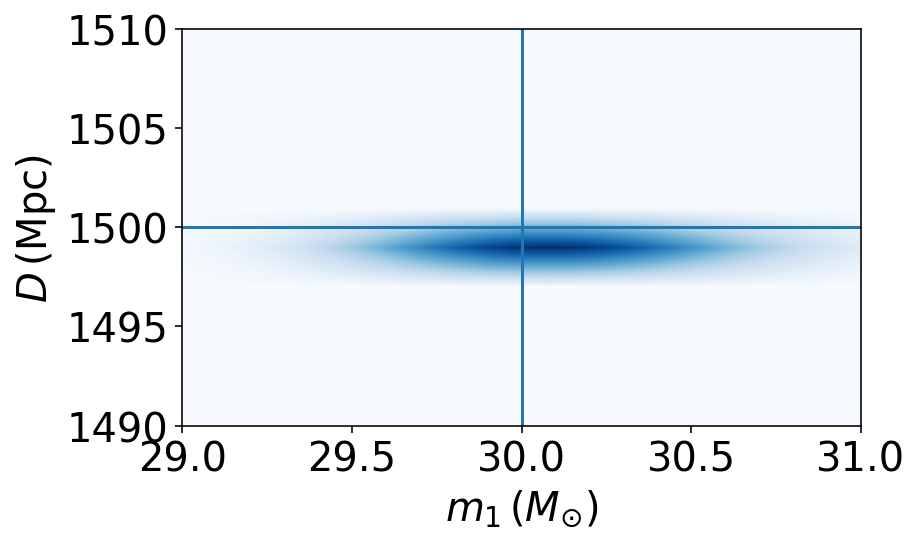

In [0]:
plt.imshow(twoD_post_regularized,origin='lower',
          extent=[29,31,1400,1600],aspect='auto',
          interpolation='bilinear',cmap=plt.cm.Blues)
plt.axhline(1500)
plt.axvline(30)
plt.ylim(1490,1510)
plt.xlabel(r'$m_1\,(M_{\odot})$')
plt.ylabel(r'$D\,(\mathrm{Mpc})$')
plt.savefig("/content/gdrive/My Drive/InvisibleUniverse/images/p_m1_D.png",bbox_inches='tight',dpi=100)

## Hypothesis testing


### Our objective

In our new notation, the Odds ratio is

* $O_{S,N}=\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$



The evidence can be found by marginalizing the likelihood $\times$ prior over the 2D parameter space. As we are dealing with very small probabilities, it's way easier to work solely with log probabilities. We can perform the 2D integrals using the handy $\texttt{logsumexp}$ function in $\texttt{scipy}$. 

Recall:

* $Z(d|\mathcal{H}_i) = \int d\theta\, \pi(\theta) \mathcal{L}(d|\theta, \mathcal{H}_i)$

which in our case is a 2D integral over A and f


* $Z(d|\mathcal{H}_S) = \int d m_1\,dD\, \pi(m_1,D) \mathcal{L}(d|(m_1,D), \mathcal{H}_S)$

In [0]:
from scipy.special import logsumexp

dm1 = m1_grid[1]-m1_grid[0]
dD = D_grid[1]-D_grid[0]
## perform 2D integration
# first integrate over m1
integrate_over_m1 = logsumexp(twoD_log_post,axis=0,b=dm1)    
# now integrate over D 
log_evidence = logsumexp(integrate_over_m1,b=dD)
print(log_evidence)

853796.3219427508


We find that 

* $Z(d|\mathcal{H}_S) =  853796.3$

and the noise evidence is unchanged. In our new notation:

* $Z(d|\mathcal{H}_N) =  853195.3$


Again, let's assume equal prior probabilities so that $P(\mathcal{H}_S|I) = P(\mathcal{H}_N|I)$ and 

* $O_{S,N}=\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$

and 

* $\ln O_{S,N} = 853796.3 - 853195.3 = 601$

Recall, that previously we had

* $\ln O_{S,N}= 609.1$



## Occam's Razor

Notice that the Odds Ratio is smaller than when we knew the signal exactly.

<img src="https://docs.google.com/uc?export=download&id=1_u0wcLT3USf4jOoMpldPVfvb73La52DA" width="350">


This is an example of $\textbf{Occam’s Razor}$: "The simplest explanation is probably the correct one." 

We introduce uncertainty by introducing more free parameters to our models and incur a “probabilistic penalty”. By expanding the parameter space, the probability of the signal hypothesis is "smeared out" over the prior volume as we allow for more ways in which the data could be realized. This lowers the probability of the $\textit{specific}$ realization of the data that we actually have.

As a rule of thumb, the simplest hypothesis is usually favored, i.e., the one with the fewest parameters. However, this must be taken with a pinch of salt. Obviously, the correct model should be favored, irrespective of its intrinsic dimensionality. What we really mean is that $\textit{overly-complex}$ models get penalized.


# Low-dimensional representations: Marginalized 1D PDFs

It is often useful to look at 1D projections of the full posterior, i.e., 1D PDFs that give the probability of $\text{just}$ the amplitude or just the frequency. The 1D PDFs are obtained by marginalizing over the other parameters, for example:

* $p(m_1|d,\mathcal{H}_S) = \int\,dD\, p(\theta=(m_1,D)|d,\mathcal{H}_S)$ 
* $p(D|d,\mathcal{H}_S) = \int\,dm_1\, p(\theta=(m_1,D)|d,\mathcal{H}_S)$ 



In [0]:
from scipy.special import logsumexp

# normalize the 2D PDF:

twoD_log_post_normalized = twoD_log_post - log_evidence

# integration elements
dm1 =  m1_grid[1]-m1_grid[0]
dD = D_grid[1]-D_grid[0]

# log of the 1D pdfs
log_pdf_m1 = logsumexp(twoD_log_post_normalized,axis=0,b=dD)    
log_pdf_D = logsumexp(twoD_log_post_normalized,axis=1,b=dm1)


Text(0.5,0,'$m1 (M_{\\odot})$')

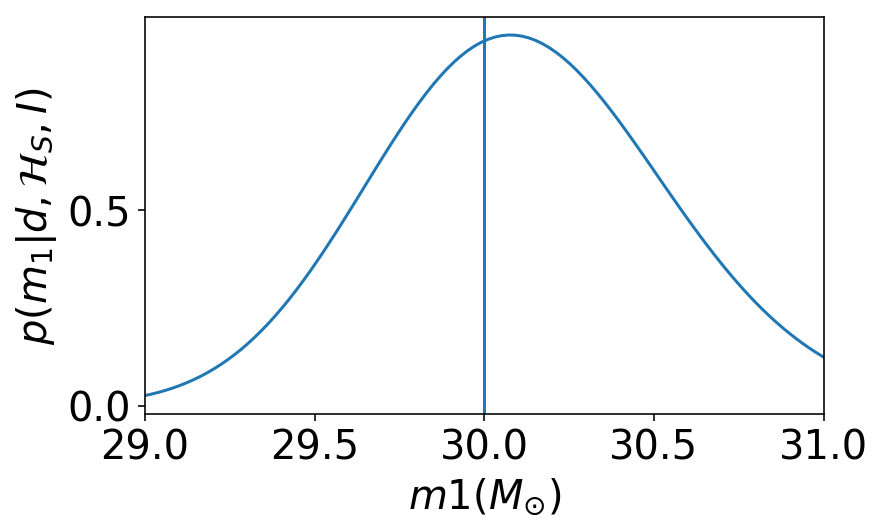

In [0]:
plt.plot(m1_grid, np.exp(log_pdf_m1))
plt.axvline(30)
plt.xlim(29,31)
plt.ylabel(r'$p(m_1|d,\mathcal{H}_S,I)$')
plt.xlabel(r'$m1 (M_{\odot})$')


(1475, 1525)

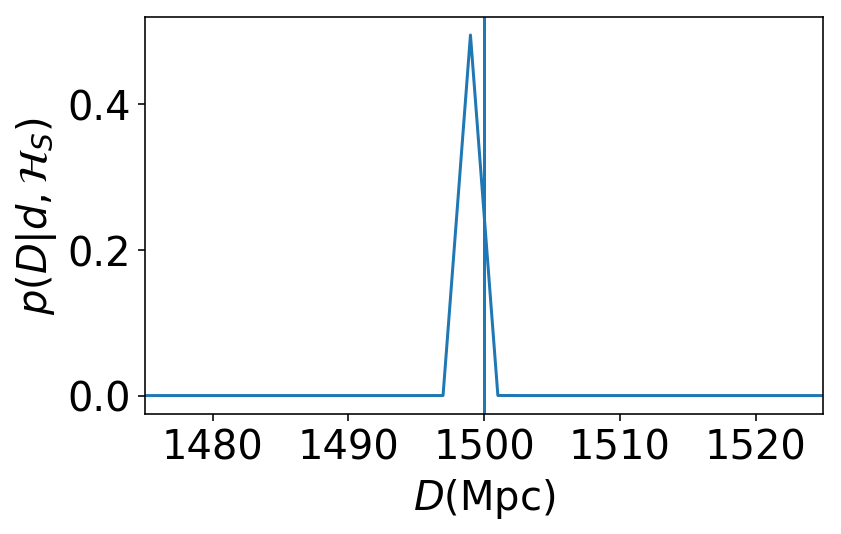

In [0]:

plt.plot(D_grid, np.exp(log_pdf_D))
plt.axvline(1500)
plt.ylabel('$p(D|d,\mathcal{H}_S)$')
plt.xlabel(r'$D (\mathrm{Mpc})$')
plt.xlim(1475,1525)

# When is a signal detectable? And, when is an hypothesis true?
## How big does the Odds ratio have to be?


This is often a very subjective question and is often where folk lore creeps in. The question of detectability (using the Odds ratio) is really
* How strongly do the odds have to favor one hypothesis over another

Many authors have different criterion, rules of thumb, and lore. For instance, Jeffreys suggested the following table (from wikipedia)

<img src="https://docs.google.com/uc?export=download&id=1PwfwgIVN-S3wJyf6GXjlrkW3_7TdSvbl" width="400">


* Here, K is essentially the Odds ratio

Another widely cited table from Kass and Raftery (1995) suggests:

<img src="https://docs.google.com/uc?export=download&id=19_Up_2uy0f1DwNzR8s6NR64MW1cGsGKA" width="418">


* Which one, if any, should we use?

I think tables and rules of thumb such as these, while possibly giving a good baseline, are unnecessary and belie the true meaning of the Odds ratio. 

* The odds give a natural interpretation of the relativie probabilities of two competing hypotheses

A "natural" way of deciding when to believe an hypothesis is true (as measured against a null hypothesis, e.g., the data are noise) would be to ask "what is the acceptable false detection rate?". 

For instance, if we set a threshold odds ratio of 

* $O_{S,N} = 1/3 \,,$

it would mean that data $\textit{on}$ the threshold would yield false detections $2/3$ of the time. Similarly, odds ratios that are marginally higher would also allow for false detections with high frequency.

<img src="https://docs.google.com/uc?export=download&id=1qrbl4uBqtVqU0G6suaSeMsxIayOVTijy" width="418">

(Ashton et al (Monash U, 2019), in prep)

* $\mathcal{R} = \frac{\text{Number of signal instances with}\, O_{S,N} }{\text{Number of noise instances with}\, O_{S,N}}$

* Correct Odds $\rightarrow$ $\mathcal{R} = O_{S,N}$

* Intuitively: an odds of X implies it is X-times
more probable a signal than noise.

I won't suggest what is a good Odds-ratio threshold: this is up to the specifics of the experiment, the use of the data, and the judgement of the data analysts. Rather, I recommend taking the Odds ratio at face value and picking a threshold value that is sufficient to only allow false detections at some acceptable rate. 


# Summary

* Hypothesis testing:
    * Constructed the Odds ratio to assign probabiilities to hypotheses of the data
    * Computed $\textit{evidences}$: the probability of the data under an hypothesis
    * Marginalized over free parameters to compute evidences where we are uncertain about models
* Parameter estimatimation:
    * Constructed $\textit{posterior PDFs}$ that give the probability of model parameters
    * Constructed $\textit{likelihood}$ functions and proiors 
    * Integrated prior-weighted likelihoods over parameters to comptue evidences 
* Marginalization:
    * Constructed 1D PDFs from 2D